<a href="https://colab.research.google.com/github/dfu2020/ATMS-597-SP-2020-Project-4/blob/master/Test_regression0326.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
#imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import datetime
import os
import glob

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt


In [0]:
#mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#change to your directory where you stored the files
%cd /content/drive/My Drive/Project_4/

/content/drive/My Drive/Project_4


In [0]:
##!gunzip sfc.tar.gz

In [0]:
##!tar -xf sfc.tar

## Read GFS daily tar file

In [0]:
#to merge the daily tar files
path = "daily/"
all_files = glob.glob(path + "*.csv")
all_files.sort()

list = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    list.append(df)

frame = pd.concat(list, axis=0, ignore_index=True)
frame

In [0]:
#rename columns.
frame.columns=['Time', 'TMAX', 'TMIN', 'WMAX', 'RTOT'] 

In [0]:
#save to csv.
frame.to_csv('GFS_daily_2010_2019_test.csv')

In [0]:
#!wget https://raw.githubusercontent.com/swnesbitt/ATMS-597-SP-2020/master/ATMS-597-SP-2020-Project-4/KCMI_daily.csv

In [0]:
#!wget https://raw.githubusercontent.com/swnesbitt/ATMS-597-SP-2020/master/ATMS-597-SP-2020-Project-4/KCMI_hourly.csv

In [0]:
#!wget https://raw.githubusercontent.com/swnesbitt/ATMS-597-SP-2020/master/ATMS-597-SP-2020-Project-4/daily.tar.gz

In [0]:
#!wget https://raw.githubusercontent.com/swnesbitt/ATMS-597-SP-2020/master/ATMS-597-SP-2020-Project-4/prof.tar.gz

In [0]:
#!wget https://raw.githubusercontent.com/swnesbitt/ATMS-597-SP-2020/master/ATMS-597-SP-2020-Project-4/sfc.tar.gz

In [0]:
#now read in the KCMI hourly data.
KCMI_hourly = pd.read_csv('KCMI_hourly.csv')  

KCMI_hourly_prec = KCMI_hourly[['pr1h']] #read in the hourly precip
KCMI_hourly_prec = KCMI_hourly_prec.set_index(KCMI_hourly['Timestamp'])  # copy the hourly timestamp
KCMI_hourly_prec.index = pd.to_datetime(KCMI_hourly_prec.index)  #change the index to datetime format

In [0]:
KCMI_hourly_prec = KCMI_hourly_prec.replace(-0.1, np.nan)   #replace the -0.1 with np.nan
KCMI_daily_prec = KCMI_hourly_prec.resample(rule='24H',closed='left',label='left',base=0).sum() #sum each day total precip

In [0]:
KCMI_daily_prec.columns=['precip_(mm)']  #rename column
KCMI_daily_prec_final = KCMI_daily_prec[(KCMI_daily_prec.index>'2009-12-31') & (KCMI_daily_prec.index<'2020')] #choose 2010-2019


In [0]:
KCMI_daily_prec_final

,precip_(mm)
Timestamp,
2010-01-01,0.0
2010-01-02,0.0
2010-01-03,0.0
2010-01-04,0.0
2010-01-05,0.0
...,...
2019-12-27,0.0
2019-12-28,2.8
2019-12-29,4.3


## Read KCMI Daily Observation

In [0]:
#read KCMI daily observations
KCMI_daily = pd.read_csv('KCMI_daily.csv', skiprows=8, parse_dates=True, index_col = 'Date')

In [0]:
KCMI_daily_new=KCMI_daily.iloc[:-7,:]   #ignore the footer
KCMI_daily_new

,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in),Unnamed: 5
Date,,,,,
2010-01-01,12,2,15,M,NaN
2010-01-02,6,-5,15,0.00,NaN
2010-01-03,10,-6,11,0.00,NaN
2010-01-04,11,-2,20,0.00,NaN
2010-01-05,10,-1,16,M,NaN
...,...,...,...,...,...
2019-12-27,43,32,15,0.00,NaN
2019-12-28,56,32,23,0.23,NaN
2019-12-29,59,41,23,0.22,NaN


In [0]:
KCMI_daily_new=KCMI_daily_new.drop(['Unnamed: 5'],axis=1)    #remove the last column


In [0]:
#rename the columns
KCMI_daily_new.rename(columns={'Max Hourly Temp (F)': 'T_MAX(F)', 'Min Hourly Temp (F)': 'T_MIN(F)', 'Max Wind Speed (mph)': 'W_MAX(mph)', 'Total Precip (in)': 'R_TOT(in)'}, inplace = True)

In [0]:
KCMI_daily_new = KCMI_daily_new.drop('R_TOT(in)',axis=1)
KCMI_daily_new

In [0]:
#add daily precipitation column from previous hourly processing
KCMI_daily_new['precip_(mm)'] = KCMI_daily_prec_final['precip_(mm)'].values

In [0]:
KCMI_daily_new

,T_MAX(F),T_MIN(F),W_MAX(mph),precip_(mm)
Date,,,,
2010-01-01,12,2,15,0.0
2010-01-02,6,-5,15,0.0
2010-01-03,10,-6,11,0.0
2010-01-04,11,-2,20,0.0
2010-01-05,10,-1,16,0.0
...,...,...,...,...
2019-12-27,43,32,15,0.0
2019-12-28,56,32,23,2.8
2019-12-29,59,41,23,4.3


In [0]:
#if you want to save the merged KCMI daily observations
KCMI_daily_new.to_csv('KCMI_daily_with_precip.csv')

In [0]:
KCMI_daily_new['T_MAX(F)']

Date
2010-01-01    12
2010-01-02     6
2010-01-03    10
2010-01-04    11
2010-01-05    10
              ..
2019-12-27    43
2019-12-28    56
2019-12-29    59
2019-12-30    38
2019-12-31    33
Name: T_MAX(F), Length: 3652, dtype: object

In [0]:
#now converting the units

#removing the Missing values
KCMI_daily_new=KCMI_daily_new.iloc[:,:].replace('M', np.nan)

# Convert TMAX,TMIN to Celcius, W_MAX to m/s
KCMI_daily_new['T_MAX(C)'] = (KCMI_daily_new['T_MAX(F)'].astype(float) - 32) * 5/9
KCMI_daily_new['T_MIN(C)'] = (KCMI_daily_new['T_MIN(F)'].astype(float)- 32) * 5/9
KCMI_daily_new['W_MAX(m/s)'] = KCMI_daily_new['W_MAX(mph)'].astype(float) * 0.44704
KCMI_daily_new['R_TOT(mm)'] = KCMI_daily_new['precip_(mm)']

KCMI_daily_final=KCMI_daily_new.iloc[:,4:]

In [0]:
KCMI_daily_final=KCMI_daily_new.iloc[:,4:]

In [0]:
#save the final daily KCMI observation csv
KCMI_daily_final.to_csv('KCMI_daily_format.csv')

,T_MAX(C),T_MIN(C),W_MAX(m/s),R_TOT(mm)
Date,,,,
2010-01-01,-11.111111,-16.666667,6.70560,0.0
2010-01-02,-14.444444,-20.555556,6.70560,0.0
2010-01-03,-12.222222,-21.111111,4.91744,0.0
2010-01-04,-11.666667,-18.888889,8.94080,0.0
2010-01-05,-12.222222,-18.333333,7.15264,0.0
...,...,...,...,...
2019-12-27,6.111111,0.000000,6.70560,0.0
2019-12-28,13.333333,0.000000,10.28192,2.8
2019-12-29,15.000000,5.000000,10.28192,4.3


## Combine features

In [0]:
#read in GFS Daily
GFS_daily = pd.read_csv('GFS_daily_2010_2019_test.csv', index_col='Time',parse_dates=True) #read in previously merged GFS daily file
GFS_daily = GFS_daily.iloc[:,1:]  #drop the unnamed column
GFS_daily_new = GFS_daily[(GFS_daily.index > '2009-12-31') & (GFS_daily.index < '2020-01-01')] #choose 2010-2019 data
GFS_daily_new

,TMAX,TMIN,WMAX,RTOT
Time,,,,
2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05
2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00
2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06
2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17
2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77
...,...,...,...,...
2019-12-27 12:00:00,13.94,3.54,8.819297,2.73
2019-12-28 12:00:00,15.94,9.34,9.701546,11.58
2019-12-29 12:00:00,7.24,-1.66,11.111256,2.57


In [0]:
#Read in KCMI Daily
KCMI_daily = pd.read_csv('KCMI_daily_format.csv', index_col = 'Date', parse_dates = True)
KCMI_daily.index = KCMI_daily.index + pd.DateOffset(hours=12)  
KCMI_daily_new = KCMI_daily.rename_axis('Time')
KCMI_daily_new

,TMAX(C),TMIN(C),WMAX(M/s),PREC(mm)
Time,,,,
2010-01-01 12:00:00,-11.111111,-16.666667,6.70560,0.0
2010-01-02 12:00:00,-14.444444,-20.555556,6.70560,0.0
2010-01-03 12:00:00,-12.222222,-21.111111,4.91744,0.0
2010-01-04 12:00:00,-11.666667,-18.888889,8.94080,0.0
2010-01-05 12:00:00,-12.222222,-18.333333,7.15264,0.0
...,...,...,...,...
2019-12-27 12:00:00,6.111111,0.000000,6.70560,0.0
2019-12-28 12:00:00,13.333333,0.000000,10.28192,2.8
2019-12-29 12:00:00,15.000000,5.000000,10.28192,4.3


In [0]:
#combine GFS Daily with KCMI Daily
feature_matrix = pd.merge(GFS_daily_new.reset_index(), KCMI_daily_new.reset_index(), on = 'Time', how = 'inner')
feature_matrix = feature_matrix.dropna()

In [0]:
#get the difference betweeen model and observation
feature_matrix['delta_TMAX']= feature_matrix['TMAX']-feature_matrix['TMAX(C)']
feature_matrix['delta_TMIN']= feature_matrix['TMIN']-feature_matrix['TMIN(C)']
feature_matrix['delta_WMAX']= feature_matrix['WMAX']-feature_matrix['WMAX(M/s)']
feature_matrix['delta_PREC']= feature_matrix['RTOT']-feature_matrix['PREC(mm)']


In [0]:
#add a year column for validation purposes
feature_matrix['year'] = feature_matrix['Time'].dt.year

In [0]:
feature_matrix

,Time,TMAX,TMIN,WMAX,RTOT,TMAX(C),TMIN(C),WMAX(M/s),PREC(mm),delta_TMAX,delta_TMIN,delta_WMAX,delta_PREC,year
0,2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05,-11.111111,-16.666667,6.70560,0.0,-0.148889,0.206667,0.618333,0.05,2010
1,2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00,-14.444444,-20.555556,6.70560,0.0,4.284444,4.595556,-2.018383,0.00,2010
2,2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06,-12.222222,-21.111111,4.91744,0.0,2.262222,6.751111,1.023940,0.06,2010
3,2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17,-11.666667,-18.888889,8.94080,0.0,3.206667,6.028889,-3.255732,0.17,2010
4,2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77,-12.222222,-18.333333,7.15264,0.0,5.062222,7.273333,-3.357907,0.77,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3609,2019-12-27 12:00:00,13.94,3.54,8.819297,2.73,6.111111,0.000000,6.70560,0.0,7.828889,3.540000,2.113697,2.73,2019
3610,2019-12-28 12:00:00,15.94,9.34,9.701546,11.58,13.333333,0.000000,10.28192,2.8,2.606667,9.340000,-0.580374,8.78,2019
3611,2019-12-29 12:00:00,7.24,-1.66,11.111256,2.57,15.000000,5.000000,10.28192,4.3,-7.760000,-6.660000,0.829336,-1.73,2019
3612,2019-12-30 12:00:00,-0.36,-2.26,8.769265,0.04,3.333333,-0.555556,11.62304,0.6,-3.693333,-1.704444,-2.853775,-0.56,2019


In [0]:
#df = df.apply(pd.to_numeric, errors='coerce')
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3576 entries, 0 to 3613
Data columns (total 14 columns):
Time          3576 non-null datetime64[ns]
TMAX          3576 non-null float64
TMIN          3576 non-null float64
WMAX          3576 non-null float64
RTOT          3576 non-null float64
TMAX(C)       3576 non-null float64
TMIN(C)       3576 non-null float64
WMAX(M/s)     3576 non-null float64
PREC(mm)      3576 non-null float64
delta_TMAX    3576 non-null float64
delta_TMIN    3576 non-null float64
delta_WMAX    3576 non-null float64
delta_PREC    3576 non-null float64
year          3576 non-null int64
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 419.1 KB


In [0]:
#check the correlation between different features.
feature_matrix.corr()[['TMAX(C)']].sort_values('TMAX(C)')

,TMAX(C)
delta_TMAX,-0.342692
WMAX,-0.266105
WMAX(M/s),-0.240260
delta_TMIN,-0.198622
year,-0.007860
delta_WMAX,0.026706
delta_PREC,0.040836
PREC(mm),0.085062
RTOT,0.126038
TMIN,0.930014


##Linear Regression

In [0]:
predictors = ['TMAX', 'TMIN', 'WMAX','RTOT'] 
new_features = feature_matrix[['TMAX(C)']+ predictors + ['year']] #the only reason we are keeping the years is for sample splitting purposes

In [0]:
# separate our my predictor variables (X) from my outcome variable y
X = new_features[predictors]
y = new_features['TMAX(C)']

# Add a constant to the predictor variable set to represent the Bo intercept
#X = sm.add_constant(X)
#X.ix[:5, :5]

In [0]:
X_train = new_features[new_features['year']< 2019][predictors]
X_test = new_features[new_features['year']== 2019][predictors]
y_train = new_features[new_features['year']< 2019]['TMAX(C)']
y_test = new_features[new_features['year']== 2019]['TMAX(C)']


In [0]:
y_train.shape

(3213,)

In [0]:
regressor = LinearRegression()

# fit the build the model by fitting the regressor to the training data
regressor.fit(X_train, y_train)

# make a prediction set using the test set
prediction = regressor.predict(X_test)

# Evaluate the prediction accuracy of the model
from sklearn.metrics import mean_absolute_error, median_absolute_error
print("The Explained Variance: %.2f" % regressor.score(X_test, y_test))
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, prediction))
print("The Root Mean Square Error: %.2f degrees celsius " %  sqrt(mean_squared_error(y_test, prediction)))

The Explained Variance: 0.86
The Mean Absolute Error: 3.37 degrees celsius
The Median Absolute Error: 2.64 degrees celsius
The Root Mean Square Error: 4.37 degrees celsius 


In [0]:
print("Model slope:    ", regressor.coef_[0])
print("Model intercept:", regressor.intercept_)

Model slope:     0.5557321833670297
Model intercept: 4.753463224356244


In [0]:
time = feature_matrix[feature_matrix['year']==2019]['Time'].values

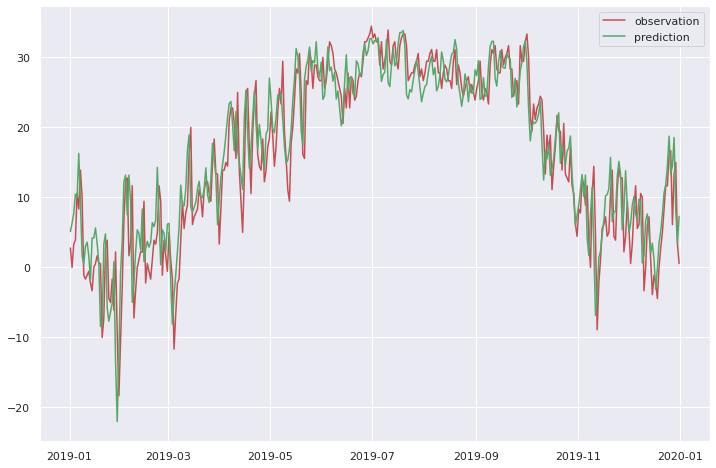

In [0]:
plt.figure(figsize=(12, 8))
plt.plot(time,y_test,c='r',label='observation')
plt.plot(time,prediction, c='g',label='prediction')
plt.legend()
plt.show()